# Explore mapped fields in Argovis

## Setup

In addition to importing a few python packages, make sure to plug in your Argovis API key for API_KEY in the next cell. If you don't have a free Argovis API key yet, get one at https://argovis-keygen.colorado.edu/.

In [1]:
from argovisHelpers import helpers as avh

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt # e.g. to change the size of figures created from functions
import copy

from Argovis_tasks_helpers import get_route,list_values_for_parameter_to_api_query,show_variable_names_for_collections
from Argovis_tasks_helpers import get_api_output_formatted_list_1var_for_regions_and_timeranges
from Argovis_tasks_helpers import api_output_formatted_list_1var_plot_map

# from Argovis_tasks_helpers import grids_to_xarray
# import numpy as np
# import pandas
# import xarray as xr

API_ROOT='https://argovis-api.colorado.edu/'
API_KEY=''

In [2]:
# for a list of collections, please see the Argovis swagger page

#### in the following we set parameters to plot different gridded products
selection_params = {}
#+++ example to use Argo profile data and the glodap gridded product (which provides time mean fields)
selection_params['collections']  = ['timeseries/noaasst',
                                   'timeseries/copernicussla',
                                   'timeseries/ccmpwind',
                                   'grids/rg09',
                                   'grids/glodap',
                                   'grids/kg21']
# selection_params['collections']  = ['grids/rg09',
#                                    'grids/glodap',
#                                    'grids/kg21']
#+++


In [3]:
# for each selected collection, we list the variables that are available
vars_lists = show_variable_names_for_collections(collections_list=selection_params['collections'],API_KEY=API_KEY,verbose=True)


https://argovis-api.colorado.edu/timeseries/noaasst/vocabulary?parameter=data
>>>>> timeseries/noaasst
['sst']
https://argovis-api.colorado.edu/timeseries/copernicussla/vocabulary?parameter=data
>>>>> timeseries/copernicussla
['sla', 'adt', 'ugosa', 'ugos', 'vgosa', 'vgos']
https://argovis-api.colorado.edu/timeseries/ccmpwind/vocabulary?parameter=data
>>>>> timeseries/ccmpwind
['uwnd', 'vwnd', 'ws', 'nobs']
https://argovis-api.colorado.edu/grids/rg09/vocabulary?parameter=data
>>>>> grids/rg09
['rg09_salinity', 'rg09_temperature']
https://argovis-api.colorado.edu/grids/glodap/vocabulary?parameter=data
>>>>> grids/glodap
['Cant', 'Cant_Input_N', 'Cant_Input_mean', 'Cant_Input_std', 'Cant_error', 'Cant_relerr', 'NO3', 'NO3_Input_N', 'NO3_Input_mean', 'NO3_Input_std', 'NO3_error', 'NO3_relerr', 'OmegaA', 'OmegaA_Input_N', 'OmegaA_Input_mean', 'OmegaA_Input_std', 'OmegaA_error', 'OmegaA_relerr', 'OmegaC', 'OmegaC_Input_N', 'OmegaC_Input_mean', 'OmegaC_Input_std', 'OmegaC_error', 'OmegaC_rel

In [4]:
# indicate the variable of interest for each collection
selection_params['varnames']     = ['sst','sla','ws','rg09_temperature', 'temperature', 'kg21_ohc15to300']
# let's indicate if we would like to store extra variables in addition to the ones above: 
# points will be returned only if they have (for that collection) the variable indicated
# above AND any variable indicated in data_extra (i.e. for gridded products this is not
# a real constraint as all the variables that are available, are available at all the 
# locations on the grid
# do not forget to include a comma at the start of the string, e.g. ',salinity,temperature'
selection_params['data_extra']   = ['',',ugos,vgos',',uwnd,vwnd',
                                    ',rg09_salinity',',oxygen','']

In [5]:
for i,ilist in enumerate(vars_lists):
    if selection_params['varnames'][i] not in ilist:
        print('>>>>> '+selection_params['collections'][i]+' does not include selected variable, i.e. '+selection_params['varnames'][i])
        print('Here is a list of the variables that are included:')
        print(ilist)
        change_name_of_selected_variable_before_continuing
    else:
        print('>>>>> '+selection_params['collections'][i]+' includes selected variable, i.e. '+selection_params['varnames'][i])

>>>>> timeseries/noaasst includes selected variable, i.e. sst
>>>>> timeseries/copernicussla includes selected variable, i.e. sla
>>>>> timeseries/ccmpwind includes selected variable, i.e. ws
>>>>> grids/rg09 includes selected variable, i.e. rg09_temperature
>>>>> grids/glodap includes selected variable, i.e. temperature
>>>>> grids/kg21 includes selected variable, i.e. kg21_ohc15to300


In [6]:
# for each collection, we show the time period of interest
# (please note that this code will be updated in the near future to leverage upcoming summary documemnts for each collection; at that point, the information of interest will be accessed in the same way for all the collections)
for icollection in selection_params['collections']:
    metaQuery = {'id': icollection.split('/')[1]}
    print('--> '+icollection)
    meta = avh.query(icollection.split('/')[0]+'/meta', options=metaQuery, apikey=API_KEY, apiroot=get_route(icollection),verbose=True)
    
    try:
        for imeta in meta:
            if 'timeseries' in imeta.keys():
                print('Time period available:')
                print(imeta['timeseries'][0])
                print(imeta['timeseries'][-1])
    except:
        # this is a temporary fix and only works for grids/
        options = {'box': [[-60,27],[-59, 28]]}
        bfr     = avh.query(icollection, options=options, apikey=API_KEY, apiroot=get_route(icollection),verbose=False)
        bfr_time= [x['timestamp'] for x in bfr]
        print('Time period available:')
        print(min(bfr_time))
        print(max(bfr_time))
        

--> timeseries/noaasst
https://argovis-api.colorado.edu/timeseries/meta?id=noaasst
Time period available:
1989-12-31T00:00:00.000Z
2023-01-29T00:00:00.000Z
--> timeseries/copernicussla
https://argovis-api.colorado.edu/timeseries/meta?id=copernicussla
Time period available:
1993-01-03T00:00:00.000Z
2022-07-24T00:00:00.000Z
--> timeseries/ccmpwind
https://argovis-api.colorado.edu/timeseries/meta?id=ccmpwind
Time period available:
1993-01-03T00:00:00.000Z
2019-12-29T00:00:00.000Z
--> grids/rg09
https://argovis-api.colorado.edu/grids/meta?id=rg09
Time period available:
2004-01-15T00:00:00.000Z
2022-05-15T00:00:00.000Z
--> grids/glodap
https://argovis-api.colorado.edu/grids/meta?id=glodap
--> grids/kg21
https://argovis-api.colorado.edu/grids/meta?id=kg21
Time period available:
2005-01-15T00:00:00.000Z
2020-12-15T00:00:00.000Z


In [7]:
#### params varying with the region

# in this example, we will use the 'box' selection type (i.e. we query the data within boxes),
# hence we indicate here the bottom/left and top/right vertices for each box of interest... 
# the other option is to search in a 'polygon' and indicate the polygon
# vertices in a list (first and last vertex should be the same)
selection_params['regions']     = [
                        [[-55.5,35.5],[-45.5,40.5]],
                        ]
selection_params['regions_type'] = ['box', 'box']

selection_params['regions_tag'] = ['Atlantic','Pacific',]
####

In [8]:
# list of startDate and endDates of interest (note: these will not be used for glodap as glodap only provides a time mean)
selection_params['startDate']    = ['2018-01-01T00:00:00Z']
selection_params['endDate']      = ['2018-01-17T00:00:00Z']

# colors to use for the line plots
colors = list(mcolors.TABLEAU_COLORS.keys())

In [9]:
# let's retrieve the data of interest
api_output_formatted_list = get_api_output_formatted_list_1var_for_regions_and_timeranges(selection_params=selection_params,API_KEY=API_KEY)


>>>>>>>>> timeseries/noaasst sst, Atlantic 2018-01-01 to 2018-01-17
https://argovis-api.colorado.edu/timeseries/noaasst?data=sst&box=[[-55.5,+35.5],+[-45.5,+40.5]]&startDate=2018-01-01T00:00:00.000000Z&endDate=2018-01-17T00:00:00.000000Z
https://argovis-api.colorado.edu/timeseries/meta?id=noaasst
>>>>>>>>> timeseries/copernicussla sla, Atlantic 2018-01-01 to 2018-01-17
https://argovis-api.colorado.edu/timeseries/copernicussla?data=sla,ugos,vgos&box=[[-55.5,+35.5],+[-45.5,+40.5]]&startDate=2018-01-01T00:00:00.000000Z&endDate=2018-01-17T00:00:00.000000Z
https://argovis-api.colorado.edu/timeseries/meta?id=copernicussla
https://argovis-api.colorado.edu/timeseries/meta?id=copernicussla
https://argovis-api.colorado.edu/timeseries/meta?id=copernicussla
>>>>>>>>> timeseries/ccmpwind ws, Atlantic 2018-01-01 to 2018-01-17
https://argovis-api.colorado.edu/timeseries/ccmpwind?data=ws,uwnd,vwnd&box=[[-55.5,+35.5],+[-45.5,+40.5]]&startDate=2018-01-01T00:00:00.000000Z&endDate=2018-01-17T00:00:00.0000

In [10]:
# api_output = copy.deepcopy(api_output_formatted_list)

In [11]:
# metaQuery = {
#     'id': api_output[0]['metadata'] 
# }

# meta = avh.query('timeseries/meta', options=metaQuery, apikey=API_KEY, apiroot=get_route(icollection),verbose=True)
# print(meta)

In [12]:
print(api_output_formatted_list[0].keys())

api_output_formatted_list[0][list(api_output_formatted_list[0].keys())[0]]

dict_keys(['sst'])


{'collection': 'timeseries/noaasst',
 'varname': 'sst',
 'data_units': 'degC',
 'data_xarray': <xarray.Dataset>
 Dimensions:    (latitude: 6, longitude: 11, levels: 1, timestamp: 2)
 Coordinates:
   * latitude   (latitude) float64 35.5 36.5 37.5 38.5 39.5 40.5
   * longitude  (longitude) float64 304.5 305.5 306.5 307.5 ... 312.5 313.5 314.5
   * levels     (levels) int64 0
   * timestamp  (timestamp) object '2018-01-07T00:00:00.000Z' '2018-01-14T00:0...
 Data variables:
     data       (latitude, longitude, levels, timestamp) float64 20.6 ... 19.16,
 'region': [[-55.5, 35.5], [-45.5, 40.5]],
 'startDate': '2018-01-01T00:00:00Z',
 'endDate': '2018-01-17T00:00:00Z',
 'region_type': 'box',
 'region_tag': 'Atlantic',
 'varname_title': 'Sst'}

In [13]:
for i in api_output_formatted_list:
    for j in i.keys():
        print(i[j]['data_xarray'])
        print(i[j]['data_units'])

<xarray.Dataset>
Dimensions:    (latitude: 6, longitude: 11, levels: 1, timestamp: 2)
Coordinates:
  * latitude   (latitude) float64 35.5 36.5 37.5 38.5 39.5 40.5
  * longitude  (longitude) float64 304.5 305.5 306.5 307.5 ... 312.5 313.5 314.5
  * levels     (levels) int64 0
  * timestamp  (timestamp) object '2018-01-07T00:00:00.000Z' '2018-01-14T00:0...
Data variables:
    data       (latitude, longitude, levels, timestamp) float64 20.6 ... 19.16
degC
<xarray.Dataset>
Dimensions:    (latitude: 20, longitude: 40, levels: 1, timestamp: 2)
Coordinates:
  * latitude   (latitude) float64 35.62 35.88 36.12 36.38 ... 39.88 40.12 40.38
  * longitude  (longitude) float64 304.6 304.9 305.1 305.4 ... 313.9 314.1 314.4
  * levels     (levels) int64 0
  * timestamp  (timestamp) object '2018-01-07T00:00:00.000Z' '2018-01-14T00:0...
Data variables:
    data       (latitude, longitude, levels, timestamp) float64 0.2222 ... 0....
m
<xarray.Dataset>
Dimensions:    (latitude: 20, longitude: 40, levels: 

In [14]:
api_output_formatted_list[0]['sst']['data_xarray'].coords['timestamp'].values[0]

'2018-01-07T00:00:00.000Z'

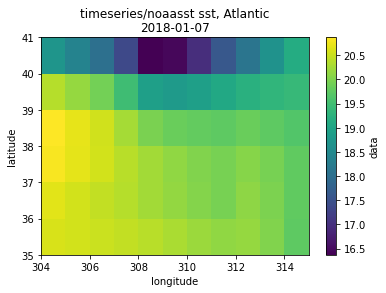

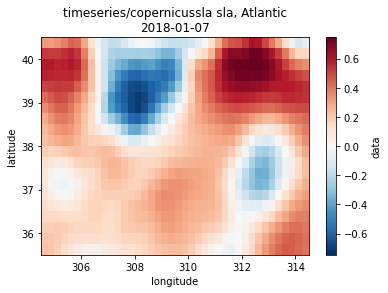

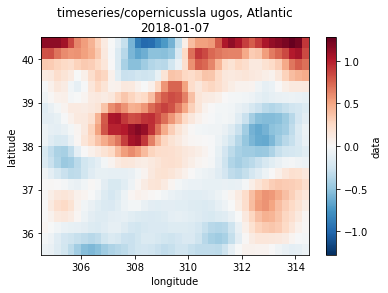

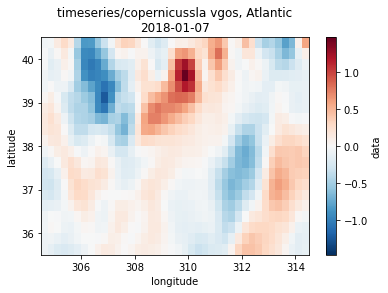

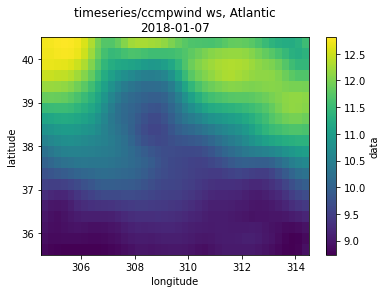

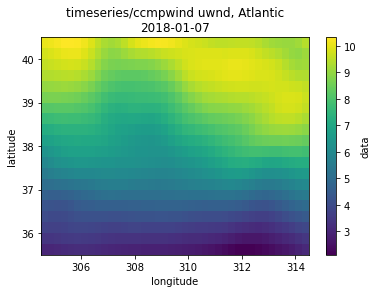

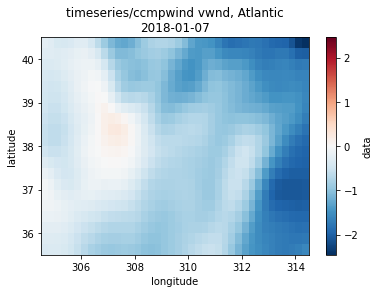

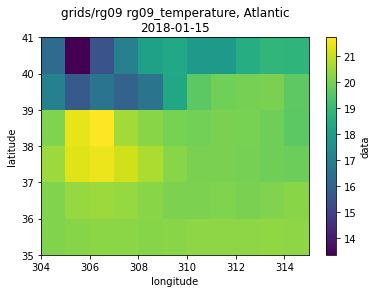

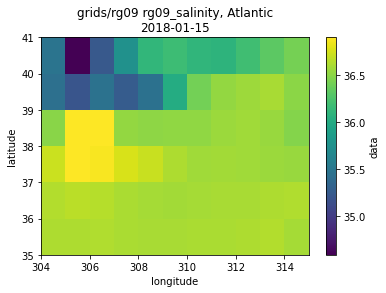

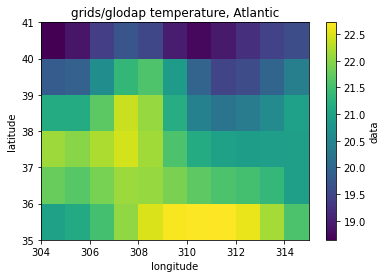

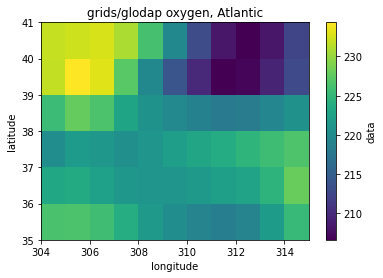

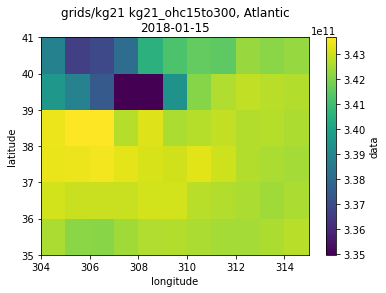

In [15]:
api_output_formatted_list_1var_plot_map(api_output_formatted_list,ilev=0,itime=0)  


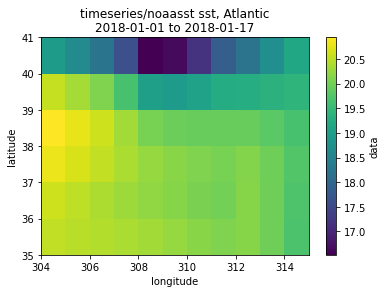

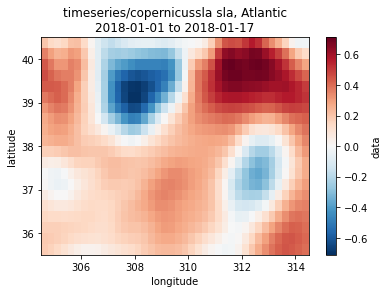

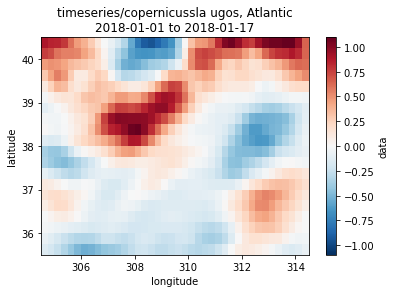

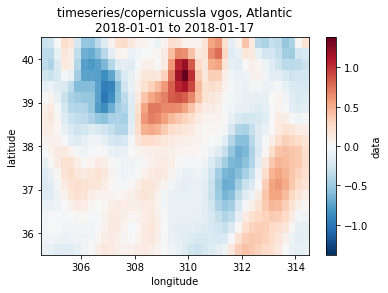

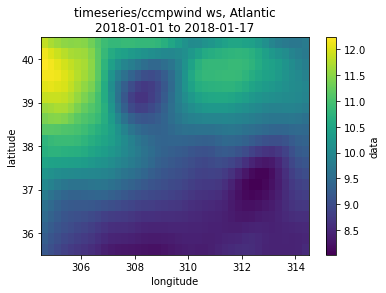

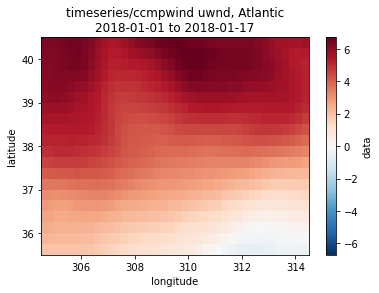

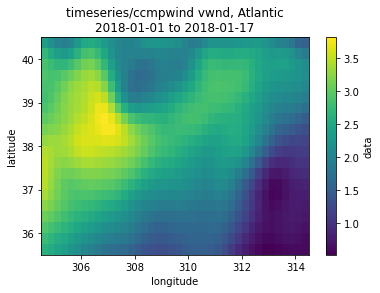

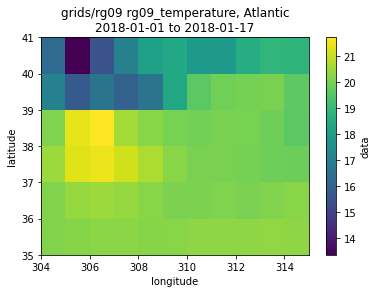

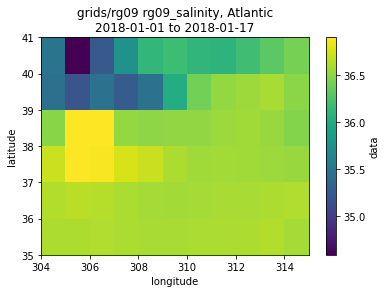

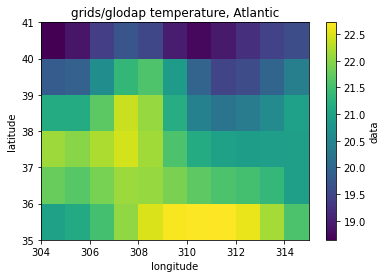

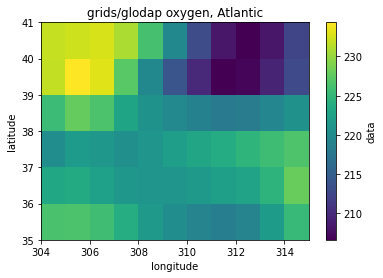

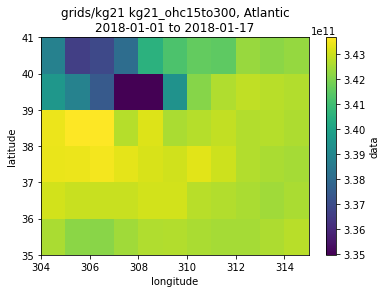

In [18]:
api_output_formatted_list_1var_plot_map(api_output_formatted_list,ilev=0,itime=[])  


In [16]:
# # function to format the output of an api query, to make visualizing it easier; if levels for vertical interpolation are provided, the function also does that (storing the output in a dedicated xarray)
# def format_api_output(api_output,selection_params,varname,index_collection,API_KEY=''):
# # api_output is the output of an API query
# # varname is the name of the variable we would like to save in the formatted output
# # selection_params is a dictionary with info about the query (documentation to be included)
# # index_collection is an integer pointing to the desired item in the list of collections within selection_params
#     api_output_formatted = {}
#     api_output_formatted['collection'] = selection_params['collections'][index_collection]
#     api_output_formatted['varname']    = varname
    
#     if api_output:
#         # create a list with information for non gridded products
#         if 'grids' not in selection_params['collections'][index_collection] and 'timeseries' not in selection_params['collections'][index_collection]:
#             # if more than one variable is included in api_output, this will only store the one indicated in varname above
#             api_output_formatted['_id']      =[x['_id'] for x in api_output]
            
#             #? the next 2 lines should be adjusted to see if we can avoid assuming the correct index is '0' for the variable name (we should be able to query the legend?)
#             api_output_formatted['data']     =[x['data'][x['data_info'][0].index(varname)] for x in api_output]
#             #print([x['data_info'][0] for x in api_output])
#             api_output_formatted['levels']   =[x['data'][x['data_info'][0].index(selection_params['varname_levels'][index_collection])] for x in api_output]
#             api_output_formatted['timestamp']=[dateutil.parser.isoparse(x['timestamp']) for x in api_output]
#             api_output_formatted['longitude']=[x['geolocation']['coordinates'][0] for x in api_output]
#             api_output_formatted['latitude'] =[x['geolocation']['coordinates'][1] for x in api_output]

#             #? the next line should be adjusted to see if we can avoid assuming the correct index is '0' for the variable name and for the units (we should be able to query the legend?)
#             api_output_formatted['data_units']=api_output[0]['data_info'][2][api_output[0]['data_info'][0].index(varname)][0]
            
#             # if interp_levels are provided, then interpolate and create an xarray
#             if 'interp_levels' in selection_params.keys():
#                 interpolated_profiles = []
#                 for idata in api_output:
#                              interpolated_profiles.append(interpolate_profiles(profile=idata, levels_varname=selection_params['varname_levels'][index_collection], levels_new=selection_params['interp_levels']))
                        
#                 # if more than one variable is included in api_output, this will only store the one indicated in varname above
#                 d = [x['data'] for x in interpolated_profiles]
#                 d = [[level[varname] for level in x] for x in d]
                    
#                 # create xarray
#                 d_ind = np.array([list(range(1,len(api_output)+1))]*len(selection_params['interp_levels'])).transpose().tolist()
#                 d_lev = [selection_params['interp_levels']]*len(api_output)
                
# #                 print(np.shape(d))
# #                 print(np.shape(d_ind))
# #                 print(np.shape(d_lev))
               
#                 data_dict = {'data': np.array(d).flatten().tolist(),'levels': np.array(d_lev).flatten().tolist(),'index':np.array(d_ind).flatten().tolist()
#                         } 
#                 data_df = pandas.DataFrame(data_dict)   
#                 df_rows = pandas.DataFrame(data_df).set_index(["levels","index"])
#                 xar     = xr.Dataset.from_dataframe(df_rows)
#                 xar     = xar.assign(longitude=(['index'],np.array(api_output_formatted['longitude'])))
#                 xar     = xar.assign(latitude=(['index'],np.array(api_output_formatted['latitude'])))
#                 xar     = xar.assign(timestamp=(['index'],np.array(api_output_formatted['timestamp'])))

#                 api_output_formatted['data_xarray'] = xar
#         elif 'grids' in selection_params['collections'][index_collection]:
#             # for grids, we only create data_xarray

#             for igm in api_output[0]['metadata']:
#                 try:
#                     # look in different meta_data documents until you find the one that has units for the variable of interest
#                     grids_opt  = {
#                         "id": igm
#                         }
#                     grids_meta = avh.query('grids/meta',options=grids_opt,verbose='true', apikey=API_KEY, apiroot=get_route(selection_params['collections'][index_collection]))
#                     #? the next line should be adjusted to see if we can avoid assuming the correct index is '0' for the variable name and for the units (we should be able to query the legend?)
#                     api_output_formatted['data_units'] = grids_meta[0]['data_info'][2][grids_meta[0]['data_info'][0].index(varname)][0] 
#                     break
#                 except:
#                     igm

#             api_output_formatted['data_xarray'] = grids_to_xarray(grids=api_output,grids_meta=grids_meta,varname=varname)
#         elif 'timeseries' in selection_params['collections'][index_collection]:
#             # this below works as is, if there is only one metadata file and it includes the info needed
#             # (i.e. data_units for all the variables and levels... if levels is absent, it will be assigned zero)
#             metaQuery = {
#                         'id': api_output[0]['metadata'] 
#                     }

#             timeseries_meta = avh.query('timeseries/meta', options=metaQuery, apikey=API_KEY, apiroot=get_route(icollection),verbose=True)

#             api_output_formatted['data_units'] = timeseries_meta[0]['data_info'][2][timeseries_meta[0]['data_info'][0].index(varname)][0] 
                    
#             api_output_formatted['data_xarray'] = timeseries_to_xarray_for1lev_case(timeseries=api_output,timeseries_meta=timeseries_meta,varname=varname)
#     return api_output_formatted

# # function to get a list of formatted api output
# def get_api_output_formatted_list_1var_for_regions_and_timeranges_new(selection_params,API_KEY):
#     # for each collection, region, and time range of interest, get api formatted output and store all in a list
#     api_output_formatted_list = []
    
#     # for consistency across datasets, if varnames_qc was not indicated for a collection, we will create it and assign it empty items
#     adding_varnames_qc = False
#     if 'varnames_qc' not in selection_params.keys():
#         selection_params['varnames_qc'] = []
#         for i in selection_params['varnames']:
#             selection_params['varnames_qc'].append('')
#         adding_varnames_qc = True

#     for icl,icollection in enumerate(selection_params['collections']):
#         for i,ireg in enumerate(selection_params['regions']):
#             for istart,iend in zip(selection_params['startDate'],selection_params['endDate']):

#                 print('>>>>>>>>> '+icollection+' '+selection_params['varnames'][icl]+', '+selection_params['regions_tag'][i]+' '+istart[0:10]+' to '+iend[0:10])

#                 data_str = selection_params['varnames'][icl]+selection_params['varnames_qc'][icl]+selection_params['data_extra'][icl]
#                 iparam = {}
#                 iparam = {'data': data_str}
#                 if ireg:
#                     iparam[selection_params['regions_type'][i]] = ireg
#                 if istart and 'glodap' not in icollection:
#                     iparam['startDate'] = istart
#                 else:
#                     istart = ''
#                     if 'glodap' in icollection:
#                         iparam['startDate'] = '1000-01-01T00:00:00.000Z'
#                 if iend and 'glodap' not in icollection:
#                     iparam['endDate']   = iend
#                 else:
#                     iend = ''
#                     if 'glodap' in icollection:
#                         iparam['endDate'] = '1000-01-02T00:00:00.000Z'
#                 api_output = avh.query(icollection, options=iparam, verbose='true',apikey=API_KEY, apiroot=get_route(icollection)) 
                
#                 api_output_formatted_all = {}
#                 for ivar in data_str.split(','):
#                     if not ivar.isnumeric() and '~' not in ivar:
                        
#                         api_output_formatted = format_api_output(api_output=api_output,selection_params=selection_params,varname=ivar,index_collection=icl,API_KEY=API_KEY) # please note that we specify varname as there may be more than one variable requested in other cases (in this specific function, we are focusing on comparing the same variable across datasets)
                        
#                         api_output_formatted_all[ivar]=api_output_formatted
#                         # include some more info from selection_params
#                         api_output_formatted_all[ivar]['region']   =ireg
#                         api_output_formatted_all[ivar]['startDate']=istart
#                         api_output_formatted_all[ivar]['endDate']  =iend

#                         api_output_formatted_all[ivar]['region_type']=selection_params['regions_type'][i]
#                         api_output_formatted_all[ivar]['region_tag']=selection_params['regions_tag'][i]
                        
#                         #api_output_formatted_all[ivar]['varname_title']=selection_params['varname_title']
#                         api_output_formatted_all[ivar]['varname_title']=ivar[0].upper()+ivar[1::]
#                     #print(api_output_formatted.keys())
#                 api_output_formatted_list.append(api_output_formatted_all)
                
#                 # let's drop anything that was added just for consistency with other products
#     if adding_varnames_qc:
#         del selection_params["varnames_qc"]
                    
#     return api_output_formatted_list


In [17]:
# def timeseries_to_xarray_for1lev_case(timeseries,timeseries_meta,varname):
#     # this is for timeseries data that only have one level
#     # if there is no levels indicated in the metadata, zero is assigned to levels (for timeseries there is always one level at the moment)
#     for ii,i in enumerate(timeseries_meta):
#         if 'levels' not in timeseries_meta[ii].keys():
#             timeseries_meta[ii]['levels'] = [0]

#     data_list        = []
#     data_list_lev    = []
#     data_list_lon    = []
#     data_list_lat    = []
#     data_list_tstamp = []
#     for x in timeseries:
#         for tx,x_time in enumerate(x['timeseries']):
#             data_list.append(x['data'][x['data_info'][0].index(varname)][tx])
            
#             data_list_lev.append(timeseries_meta[ii]['levels'][0])
#             data_list_lon.append(x['geolocation']['coordinates'][0])
#             data_list_lat.append(x['geolocation']['coordinates'][1])
#             data_list_tstamp.append(x_time)

#     bfr_lon = np.array(data_list_lon)
#     bfr_lon[bfr_lon<20] = bfr_lon[bfr_lon<20]+360

#     data_list_lon = bfr_lon.tolist()

#     data_dict = {'data': data_list,'latitude':data_list_lat, 'longitude': data_list_lon,'levels': data_list_lev,'timestamp': data_list_tstamp} 

#     data_df = pandas.DataFrame(data_dict)   
#     df_rows = pandas.DataFrame(data_df).set_index(["latitude", "longitude","levels","timestamp"])
#     return xr.Dataset.from_dataframe(df_rows)